# 문제1 : 온라인 소비자 분석(군집분석)

In [10]:
from pandas import read_csv
retail = read_csv('OnlineRetail_after.csv').drop('Unnamed: 0', axis=1)
retail

,CustomerID,Recency,Frequency,Amount
0,12346,325,2,0.00
1,12747,22,103,4196.01
2,12748,4,4642,32034.17
3,12749,22,231,3868.20
4,12820,44,59,942.34
...,...,...,...,...
3945,18280,159,10,180.60
3946,18281,3,7,80.82
3947,18282,92,13,176.60
3948,18283,9,756,2329.67


1. EDA를 통해 소비자 특성 등 인사이트를 도출하시오.

In [11]:
# 결측치는 보이지 않음
# 마지막 구매 후 흐른 날짜가 -1이 있어서 살펴봐야 할 것으로 보임 (환불?)
retail.describe()

,CustomerID,Recency,Frequency,Amount
count,3950.000000,3950.000000,3950.000000,3950.000000
mean,15562.029367,100.417975,91.614684,1742.702009
std,1576.848325,114.009397,220.557389,6556.472672
min,12346.000000,-1.000000,1.000000,-4287.630000
25%,14208.250000,19.000000,17.000000,290.505000
50%,15571.500000,57.000000,41.000000,642.395000
75%,16913.750000,152.000000,101.000000,1562.067500
max,18287.000000,696.000000,7983.000000,256438.490000


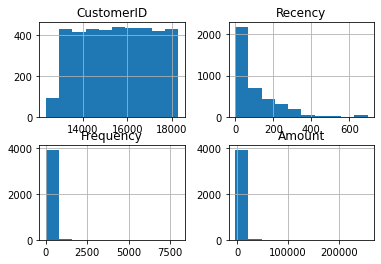

In [16]:
from matplotlib import pyplot as plt
retail.hist()
plt.show()
#Recency, Frequency, Amount 모두 최소-최대 차이가 엄청 큼 (비정규분포)

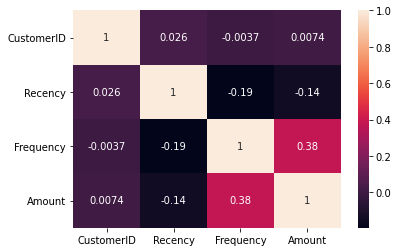

상관계수 0.38, pvalue 0.00


In [26]:
import seaborn as sns
sns.heatmap(retail.corr(), annot=True)
plt.show()

from scipy.stats import pearsonr
r, p = pearsonr(retail['Frequency'], retail['Amount'])
print("상관계수 {:.2f}, pvalue {:.2f}".format(r, p))
# Frequancy-Amount 통계적으로 유의한 상관관계 확인함 (상식적으로 생각해도 그럴듯)
# 그 외에는 상관관계가 없는 것으로 보임

2. 계층적 군집분석을 통해 고객 집단을 그룹핑하고 집단의 특성을 설명하시오.
- random_state=123(=set.seed(123)
- 비지도학습 : 'Amount', 'Frequency', ‘Recency'를 변수로 사용

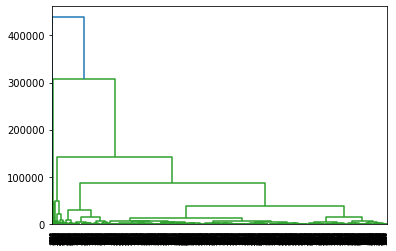

In [42]:
### 계층 클러스터링 (원본데이터)
#retail=retail.drop('CustomerID', axis=1)
#from sklearn.preprocessing import StandardScaler
#retail2 = StandardScaler().fit_transform(retail)

from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
Z = linkage(retail, method='ward')
dendrogram(Z)
plt.show()

In [46]:
result5 = DataFrame(columns=['label', 'cluster_n', 'SC'])
for i in range(4): #군집분석 4회 실시
    result5.loc[i, 'cluster_n'] = i+3
    result5.loc[i, 'label'] = 'hier(raw)'
    labels = cut_tree(Z, i+3).flatten()
    result5.loc[i, 'SC'] = silhouette_score(retail, labels)
result5

,label,cluster_n,SC
0,hier(raw),3,0.954579
1,hier(raw),4,0.842549
2,hier(raw),5,0.843404
3,hier(raw),6,0.705871


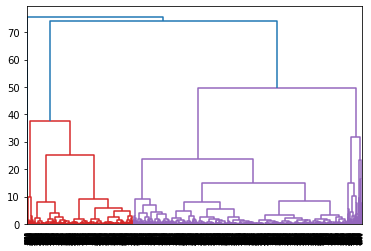

In [47]:
### 계층 클러스터링 (표준화데이터)
Z2 = linkage(retail2, method='ward')
dendrogram(Z2)
plt.show()

In [49]:
result6 = DataFrame(columns=['label', 'cluster_n', 'SC'])
for i in range(4): #군집분석 4회 실시
    result6.loc[i, 'cluster_n'] = i+3
    result6.loc[i, 'label'] = 'hier(raw)'
    labels = cut_tree(Z2, i+3).flatten()
    result6.loc[i, 'SC'] = silhouette_score(retail, labels)
result6

,label,cluster_n,SC
0,hier(raw),3,-0.070759
1,hier(raw),4,-0.073248
2,hier(raw),5,0.003512
3,hier(raw),6,-0.133073


In [55]:
# 표준화된 데이터 기반으로 계층적 군집을 3개로 나누기로 결정함
z = linkage(retail2, method='ward')
labels = cut_tree(z, 3).flatten()
labeled_data = retail.copy()
labeled_data['hier_cluster'] = labels
labeled_data

,Recency,Frequency,Amount,hier_cluster
0,325,2,0.00,0
1,22,103,4196.01,1
2,4,4642,32034.17,2
3,22,231,3868.20,1
4,44,59,942.34,1
...,...,...,...,...
3945,159,10,180.60,0
3946,3,7,80.82,1
3947,92,13,176.60,1
3948,9,756,2329.67,1


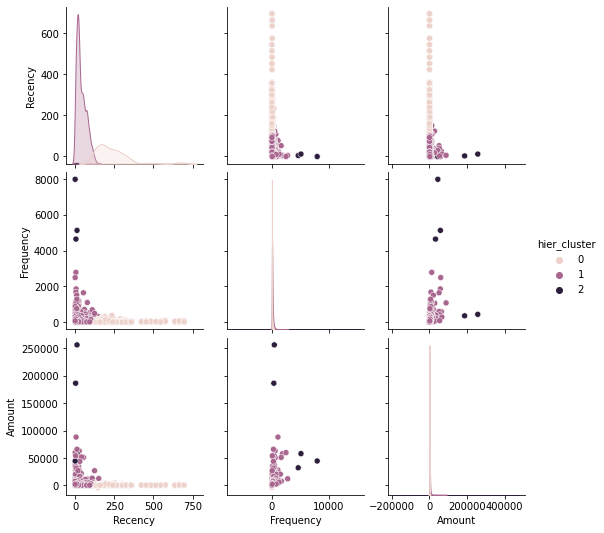

In [57]:
# cluster0은 Amount와 Frequency가 낮고, Recency가 높은 그룹이다. 즉 현재 구매가 잘 일어나지 않는 휴면 고객으로 볼 수 있다.
# cluster3은 Amount와 Frequency가 높고, Recency는 낮은 그룹이다. 활발한 구매자이다. Amount가 많이 높지않아도 Frequency가 높거나, Frequency가 좀 낮아도 Amount는 높은 편이다.
# cluster2는 Recency는 낮아서 지속적으로 구매하고 있지만, Amount와 Frequency가 낮은 편이다.
sns.pairplot(labeled_data, hue='hier_cluster')
plt.show()

3. 비계층적 분석을 통해 고객 집단을 그룹핑하고 집단의 특성을 설명하시오.
- random_state=123(=set.seed(123))
- 비지도학습 : 'Amount', 'Frequency', ‘Recency'를 변수로 사용

In [54]:
### 혼합분포 클러스터링 (원본데이터)
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from pandas import DataFrame
result = DataFrame(columns=['label', 'cluster_n', 'loglikelyhood', 'aic', 'bic', 'SC'])
for i in range(4): #군집분석 4회 실시
    result.loc[i, 'cluster_n'] = i+3
    result.loc[i, 'label'] = 'GM(raw)'
    gm = GaussianMixture(i+3, random_state=123).fit(retail) 
    #군집개수 3~6 fitting
    pred = gm.predict(retail) #predict labels
    result.loc[i, 'aic'] = gm.aic(retail)
    result.loc[i, 'bic'] = gm.aic(retail)
    result.loc[i, 'loglikelyhood'] = gm.score(retail)
    result.loc[i, 'SC'] = silhouette_score(retail, pred)
result

,label,cluster_n,loglikelyhood,aic,bic,SC
0,GM(raw),3,-19.919311,157420.553654,157420.553654,0.63961
1,GM(raw),4,-19.295622,152513.412645,152513.412645,0.414064
2,GM(raw),5,-19.112257,151084.828457,151084.828457,0.370847
3,GM(raw),6,-19.103559,151036.1192,151036.1192,0.370527


In [53]:
### 혼합분포 클러스터링 (표준화데이터)
result2 = DataFrame(columns=['label', 'cluster_n', 'loglikelyhood', 'aic', 'bic', 'SC'])
for i in range(4): #군집분석 4회 실시
    result2.loc[i, 'cluster_n'] = i+3
    result2.loc[i, 'label'] = 'GM(ss)'
    gm = GaussianMixture(i+3, random_state=123).fit(retail2) 
    #군집개수 3~6 fitting
    pred = gm.predict(retail2) #predict labels
    result2.loc[i, 'aic'] = gm.aic(retail2)
    result2.loc[i, 'bic'] = gm.aic(retail2)
    result2.loc[i, 'loglikelyhood'] = gm.score(retail2)
    result2.loc[i, 'SC'] = silhouette_score(retail2, pred)
result2

,label,cluster_n,loglikelyhood,aic,bic,SC
0,GM(ss),3,-0.98611,7848.26827,7848.26827,0.324309
1,GM(ss),4,-0.380883,3086.977909,3086.977909,0.129361
2,GM(ss),5,-0.316385,2597.440532,2597.440532,0.124269
3,GM(ss),6,-0.179304,1534.497942,1534.497942,0.094021


In [52]:
### KMeans 클러스터링 (원본데이터)
from sklearn.cluster import KMeans
result3 = DataFrame(columns=['label', 'cluster_n', 'inertia', 'SC'])
for i in range(4): #군집분석 4회 실시
    result3.loc[i, 'cluster_n'] = i+3
    result3.loc[i, 'label'] = 'KM(raw)'
    km = KMeans(i+3, random_state=123).fit(retail) #군집개수 3~6 fitting
    result3.loc[i, 'inertia'] = km.inertia_
    result3.loc[i, 'SC'] = silhouette_score(retail, km.labels_)
result3

,label,cluster_n,inertia,SC
0,KM(raw),3,26187009111.103626,0.954579
1,KM(raw),4,15509201720.522978,0.841353
2,KM(raw),5,9956590151.85486,0.767941
3,KM(raw),6,7427814545.048742,0.719526


In [58]:
### KMeans (표준화 데이터)
result4 = DataFrame(columns=['label', 'cluster_n', 'inertia', 'SC'])
for i in range(4): #군집분석 4회 실시
    result4.loc[i, 'cluster_n'] = i+3
    result4.loc[i, 'label'] = 'KM(ss)'
    km = KMeans(i+3, random_state=123).fit(retail2) #군집개수 3~6 fitting
    result4.loc[i, 'inertia'] = km.inertia_
    result4.loc[i, 'SC'] = silhouette_score(retail2, km.labels_)
result4

,label,cluster_n,inertia,SC
0,KM(ss),3,5884.987941,0.542902
1,KM(ss),4,4487.330979,0.543692
2,KM(ss),5,3280.657483,0.575122
3,KM(ss),6,2607.715823,0.549162


In [59]:
# 표준화된 데이터 기반으로 비계층적 군집을 5개로 나누기로 결정함
km = KMeans(5, random_state=123).fit(retail2)
labeled_data['km_cluster'] = km.labels_
labeled_data

,Recency,Frequency,Amount,hier_cluster,km_cluster
0,325,2,0.00,0,1
1,22,103,4196.01,1,0
2,4,4642,32034.17,2,2
3,22,231,3868.20,1,0
4,44,59,942.34,1,0
...,...,...,...,...,...
3945,159,10,180.60,0,1
3946,3,7,80.82,1,0
3947,92,13,176.60,1,0
3948,9,756,2329.67,1,4


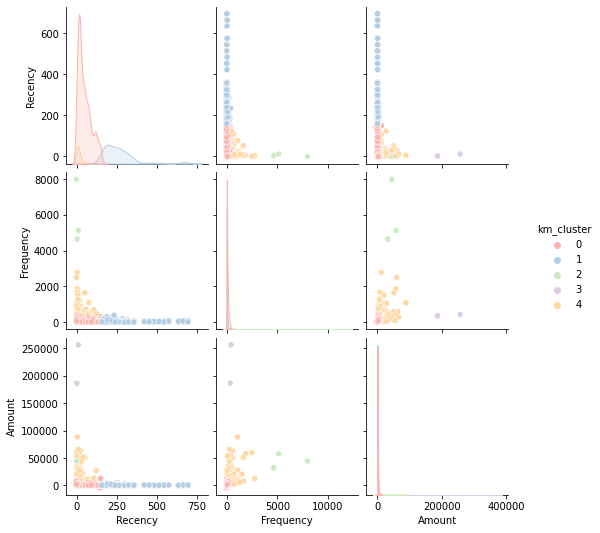

In [74]:
#cluster0은 구매빈도와 구매금액이 아주 낮은 비활성화 그룹이다. Recency가 아주 낮지는 않다.
#cluster1은 구매빈도와 구매금액이 아주 낮은 비활성화 그룹이다. Recency가 아주 낮다. cluster0과 다른 고객 전략이 필요할 것으로 보인다.
#cluster2는 구매금액은 높지 않지만, 구매 빈도가 극도로 높은 활성화 그룹이다. Recency가 아주 낮다.
#cluster3은 구매빈도는 높지 않지만, 구매금액이 극도로 높은 활성화 그룹이다. Recency도 낮다. VIP로 특별관리가 필요할 것으로 보인다.
#cluster4는 일반적인 금액과 빈도로 구매하는 활성화그룹이다.

sns.pairplot(labeled_data.drop('hier_cluster', axis=1), hue='km_cluster', palette='Pastel1')
plt.show()

4. 최종적으로 고객에 대한 마케팅 전략을 수립하시오. 

In [82]:
### 비계층적 군집분석을 통해 구분한 고객들을 대상으로 세분화한 마케팅 전략을 수립하고자 한다.
### 클러스터별 특성과 비율은 다음과 같다.
#cluster0은 비활성화, 일반적인 Recency (71%)
#cluster1은 비활성화, 극도로 낮은 Recency (24%)
#cluster4는 활성화, 일반적인 Frequency, Amount (4%)
#cluster2는 활성화, 극도로 높은 Frequency (0.07%)
#cluster3은 활성화, 극도로 높은 Amount (0.05%)
labeled_data['km_cluster'].value_counts() /len(labeled_data) *100

#고객 중 높은 비율을 차지하고 있으면서 일반적인 Recency를 가지는 비활성화 그룹인 cluster0을 대상으로 Amount 및 Frequency 증대를 위한 promotion을 진행할 것이다. 이를 통해 고객 활성화 비율을 높이고 매출 증대라는 목표를 달성할 것을 기대한다.

0    71.189873
1    24.481013
4     4.202532
2     0.075949
3     0.050633
Name: km_cluster, dtype: float64

5. 추가적인 고객 분석을 하고자 할 때 어떤 방식이 좋을지를 논하시오.

In [ ]:
# 고객들이 계절에 따른 구매 패턴 차이는 없는지 확인함으로써 계절별 고객 전략을 수립할 수 있음
# 구매량과 개별 가격에 따라 고객을 추가적으로 clustering함으로써 세분화 전략을 수립할 수 있음

# 문제2 : ’금시세와 코로나19 바이러스는 관련이 있을까?‘(시계열 분석)
(외생변수 : 미국 워싱턴 기준 코로나 19 확진자수, 종속변수 : 금 종가)

In [121]:
covid = read_csv('covid19_wc.csv').drop('Unnamed: 0', axis=1)
gold = read_csv('gold.csv').filter(['date','Close'])

1. 위 두 데이터셋을 불러와서 covid19_wc 데이터셋의 날짜 기준으로 merge(inner join)하고 [’date’, ‘ cases’, ‘ Close’] 3개의 변수를 갖는 데이터셋으로 만드시오.

In [122]:
from pandas import merge
df = merge(covid, gold, how='left', on='date')
df

,date,cases,Close
0,2020-01-21,1,1557.9
1,2020-01-22,1,1556.7
2,2020-01-23,1,1565.4
3,2020-01-24,1,1571.9
4,2020-01-25,1,NaN
...,...,...,...
839,2022-05-09,1522821,1858.6
840,2022-05-10,1522842,1841.0
841,2022-05-11,1527939,1853.7
842,2022-05-12,1528056,1824.6


2. 코로나 확진자수에 따라 금시세가 변하는지 회귀분석을 실시하시오. 

In [126]:
df = df.dropna()

#회귀모델의 F통계량과 pvalue를 봤을 때 회귀분석 모델이 통계적으로 유의함을 알 수 있다.
#즉, 확진자수에 따라 금시세가 변한다고 볼 수 있다.
from statsmodels.formula.api import ols
fitted = ols('Close ~ cases', data=df).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     104.4
Date:                Sat, 04 Jun 2022   Prob (F-statistic):           9.85e-23
Time:                        11:22:41   Log-Likelihood:                -3636.8
No. Observations:                 611   AIC:                             7278.
Df Residuals:                     609   BIC:                             7287.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1769.3226      5.331    331.908      0.000    1758.854    1779.792
cases       8.358e-05   8.18e-06     10.219      0.000    6.75e-05    9.96e-05
==============================================================================
Omnibus:                        3.608   Durbin-Watson:                   0.047
Prob(Omnibus):                  0.165   Jarque-Bera (JB):                4.201
Skew:                          -0.022   Prob(JB):                        0.122
Kurtosis:                       3.404   Cond. No.                     9.21e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [134]:
#회귀계수 분석을 위해서 변수 스케일링이 필요하다
# cases의 회귀계수는 0.3826(유의한 pvalue)으로 양의 인과관계가 있는 것으로 보인다.
from sklearn.preprocessing import StandardScaler
df2 = StandardScaler().fit_transform(df.filter(['cases', 'Close']))
df2 = DataFrame(df2, columns = ['cases', 'Close'])
fitted2 = ols('Close ~ cases', data=df2).fit()
fitted2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     104.4
Date:                Sat, 04 Jun 2022   Prob (F-statistic):           9.85e-23
Time:                        11:30:24   Log-Likelihood:                -818.62
No. Observations:                 611   AIC:                             1641.
Df Residuals:                     609   BIC:                             1650.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.797e-15      0.037   1.01e-13      1.000      -0.074       0.074
cases          0.3826      0.037     10.219      0.000       0.309       0.456
==============================================================================
Omnibus:                        3.608   Durbin-Watson:                   0.047
Prob(Omnibus):                  0.165   Jarque-Bera (JB):                4.201
Skew:                          -0.022   Prob(JB):                        0.122
Kurtosis:                       3.404   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

3. 훈련 데이터와 테스트 데이터 셋을 80:20으로 분할하여 진행하시오. 

In [235]:
idx = len(df)*0.8
#feature 생성
df['date'] = df['date'].astype('datetime64')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

#분할
train = df.loc[0:idx].set_index('date').to_period('D')
test = df.loc[idx:].set_index('date').to_period('D')

3-1. 금시세를 예측하기 위해서 금시세(종가 기준) 한 개 변수를 가지고 시계열 모델을 적합하시오.

In [215]:
from statsmodels.tsa.stattools import adfuller, kpss
r1 = adfuller(df['Close'])
print("adfuller: {:.2f}, {:.2f}".format(r1[0], r1[1])) #정상성 O

r2 = kpss(df['Close'], nlags='legacy')
print("kpss: {:.2f}, {:.2f}".format(r2[0], r2[1])) #정상성 X

diff = df['Close'].diff(1).dropna() #차분 1회
r3 = adfuller(diff)
print("adfuller: {:.2f}, {:.2f}".format(r3[0], r3[1])) #정상성 O

r4 = kpss(diff, nlags='legacy')
print("kpss: {:.2f}, {:.2f}".format(r4[0], r4[1])) #정상성 O

adfuller: -3.11, 0.03
kpss: 0.72, 0.01
adfuller: -11.48, 0.00
kpss: 0.14, 0.10


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


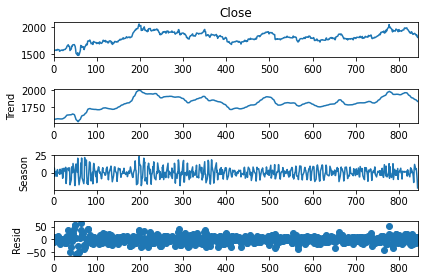

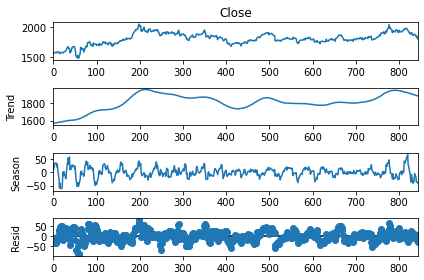

In [216]:
from statsmodels.tsa.seasonal import STL
#30일 기준으로 계절성이 있는 것처럼 보임
#Trend는 없어보임
p7= STL(df['Close'], period=7).fit()
p30= STL(df['Close'], period=30).fit()
p7.plot()
p30.plot()
plt.show()

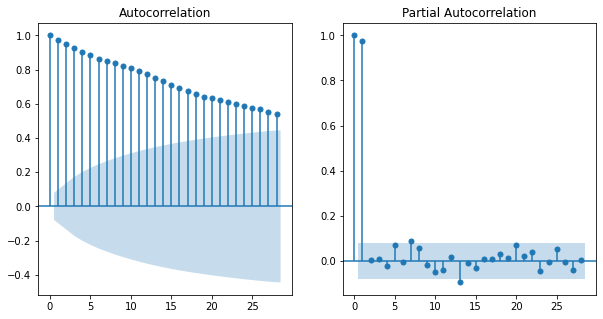

In [217]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2, figsize=(10,5))
plot_acf(df['Close'], ax=ax[0])
plot_pacf(df['Close'], ax=ax[1])
plt.show()
#ACF로 자기상관이 있음을 확인함
#acf가 점진적으로 줄고, PACF lag2에서 절단점을 갖는 것으로 보아 AR(1) 모델이 예상됨

In [333]:
from pmdarima import auto_arima
print(auto_arima(train['Close'], seasonal=True, m=7))

 ARIMA(0,1,0)(0,0,0)[7]          


In [331]:
from statsmodels.tsa.arima.model import ARIMA
model1 = ARIMA(train['Close'], order=(0,1,0)).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  352
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1585.516
Date:                Sat, 04 Jun 2022   AIC                           3173.032
Time:                        20:39:09   BIC                           3176.893
Sample:                    01-21-2020   HQIC                          3174.569
                         - 05-21-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       490.9844     22.530     21.793      0.000     446.827     535.142
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               190.81
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

3-2. 금시세를 예측하기 위해서 금시세(종가 기준)와 외생변수(코로나 확진자수)를 통해 ARIMA-X 모형을 접하시오. 


In [337]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model2 = SARIMAX(train['Close'], order=(0,1,0), seasonal_order=(0,0,0,7)).fit()
model2.summary()
#cases의 회귀계수가 유효하지 않은 것으로 나와서 삭제하고 백색잡음만 있는 상태에서의 피팅으로 진행

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  352
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1585.516
Date:                Sat, 04 Jun 2022   AIC                           3173.032
Time:                        20:42:28   BIC                           3176.893
Sample:                    01-21-2020   HQIC                          3174.569
                         - 05-21-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       490.9844     22.530     21.793      0.000     446.827     535.142
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               190.81
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

3-3. 위 두 모델에 대한 예측결과를 시각화 하시오

In [349]:
#두 모델이 동일한 모델이기 때문에 하나의 예측결과만 정리함
## Refresh 방법을 통해 백색잡음으로만 이루어진 임의보행모형을 예측함
import datetime as dt
aa = auto_arima(train['Close'], seasonal=True, m=7)
aa.fit(train['Close'])

pred = []
conf_upper = []
conf_lower = []
for data in test['Close']:
    fc, conf = aa.predict(n_periods=1, return_conf_int=True)
    fc_v = fc.tolist()[0]
    conf_v = np.asarray(conf).tolist()[0]
    lower = conf_v[0]
    upper = conf_v[1]
    #리스트에 각 값 추가
    pred.append(fc)
    conf_lower.append(lower)
    conf_upper.append(upper)
    #모델 업데이트
    aa.update(data)
aa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  611
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2698.347
Date:                Sat, 04 Jun 2022   AIC                           5398.693
Time:                        21:03:29   BIC                           5403.107
Sample:                             0   HQIC                          5400.410
                                - 611                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       407.1501     13.925     29.238      0.000     379.857     434.443
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               366.56
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

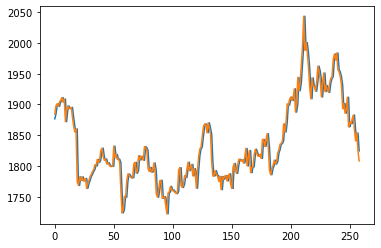

In [361]:
plt.plot(pred)
plt.plot(test['Close'].values)
plt.show()

3-4. 위 모델에 대한 잔차분석을 시행하시오.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


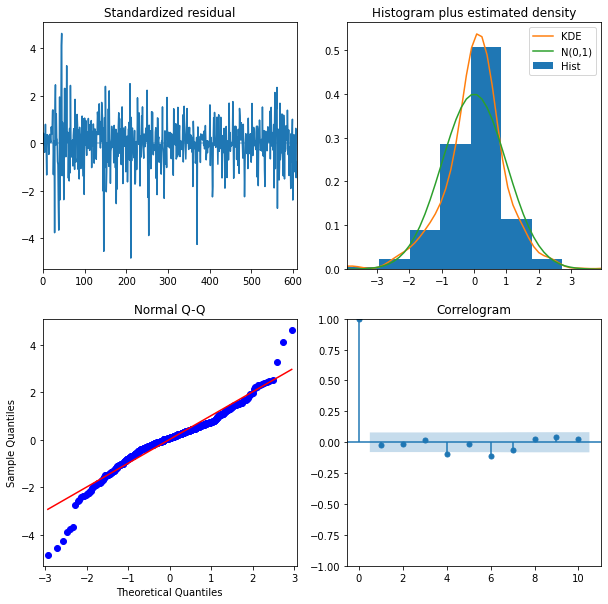

In [366]:
aa.plot_diagnostics(figsize=(10,10))
plt.show()
#QQ plot과 잔차 plot을 봤을때 정상성을 만족하지 못하지만 자기상관은 없는 데이터로 보임

In [369]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE
print(MAPE(test['Close'].values, pred))
#매우 낮은 MAPE를 보이며 잘 적합되었다고 볼 수 있음 (0에 가까울수록 잘 예측)

0.006729859806900813
